In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Importing files and defining dimension of image

width=256
height=256
channels=3

import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, get_data, shuffling

seed=42
np.random.seed=seed

In [4]:
#Defining path and getting ids of images
train_path='Phase_3/Train/Image'
train_mask_path='Phase_3/Train/Mask'
test_path='Data/test/image'
test_mask_path='Data/test/mask'

train_ids, train_mask_ids, test_ids, test_mask_ids = load_path(train_path, train_mask_path, test_path, test_mask_path)

In [5]:
#loding train and test images and randomly shuffling it
X_train, Y_train = get_data(train_path, train_mask_path, train_ids, train_mask_ids, height, width)
X_test, Y_test = get_data(test_path, test_mask_path, test_ids, test_mask_ids, height, width)
X_train, Y_train = shuffling(X_train, Y_train)
X_test, Y_test = shuffling(X_test, Y_test)

100%|██████████| 20/20 [00:00<00:00, 445.58it/s]


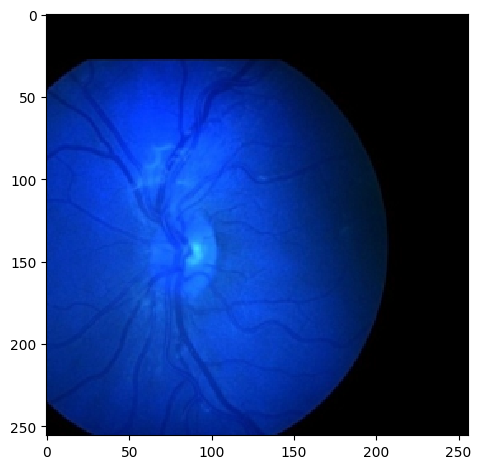

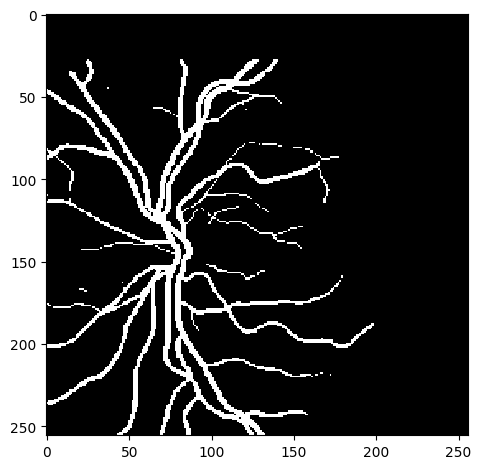

In [6]:
#testing train
img_x=random.randint(0, len(train_ids))
imshow(X_train[img_x])
plt.show()
imshow(Y_train[img_x])
plt.show()

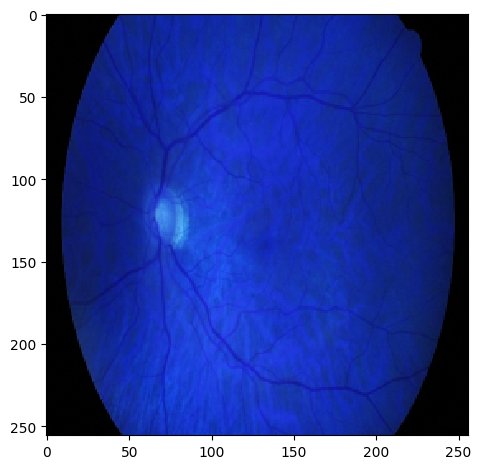

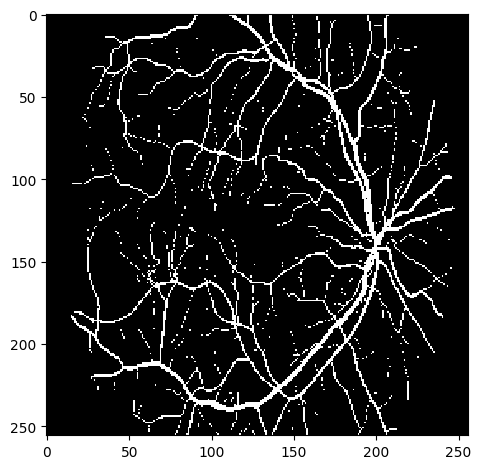

In [7]:
#testing test
img_x=random.randint(0, len(test_ids))
imshow(X_test[img_x])
plt.show()
imshow(Y_test[img_x])
plt.show()

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [9]:
#Defining parameters
batch_size = 9
lr = 1e-4
num_epochs = 10
model_path = os.path.join('model.h5')
csv_path = os.path.join('data.csv')

In [10]:
#Input Layer
input=tf.keras.layers.Input((width, height, channels))

In [11]:
#Contraction
c1=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

c2=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [12]:
#Expansion
u6=tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7=tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8=tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9=tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c1])
c9=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [13]:
#Output Layer
output=tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

In [14]:
#Model
model=tf.keras.Model(inputs=[input], outputs=[output])
model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=[dice_coef, iou, Recall(), Precision()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
_______________________________________________________________________________________

In [15]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose=1,save_best_only=True)

callbacks=[
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    CSVLogger(csv_path),
    
]

results=model.fit(X_train, Y_train, validation_split = 0.2, batch_size = batch_size, epochs = num_epochs, callbacks=callbacks)

Epoch 1/10
  1/623 [..............................] - ETA: 0s - loss: 0.8571 - dice_coef: 0.1429 - iou: 0.0770 - recall: 0.5791 - precision: 0.0723WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
623/623 [==============================] - ETA: 0s - loss: 0.7822 - dice_coef: 0.2178 - iou: 0.1224 - recall: 0.7965 - precision: 0.1237
Epoch 00001: val_loss improved from inf to 0.76659, saving model to model.h5
623/623 [==============================] - 62s 100ms/step - loss: 0.7822 - dice_coef: 0.2178 - iou: 0.1224 - recall: 0.7965 - precision: 0.1237 - val_loss: 0.7666 - val_dice_coef: 0.2335 - val_iou: 0.1322 - val_recall: 0.6703 - val_precision: 0.1413
Epoch 2/10
623/623 [==============================] - ETA: 0s - loss: 0.7542 - dice_coef: 0.245

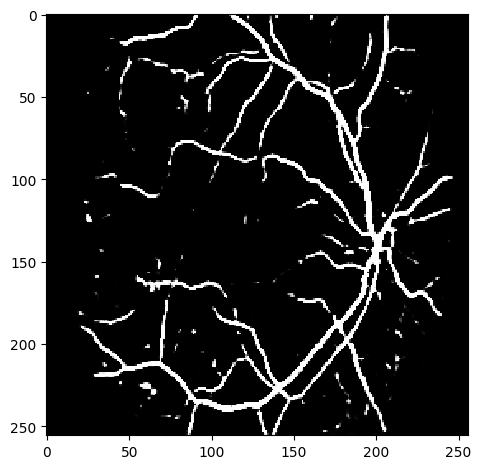

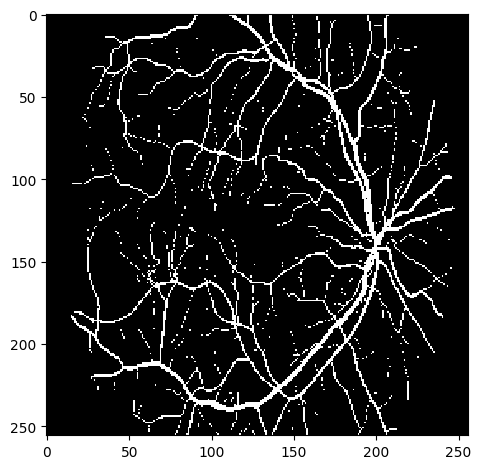

In [16]:
Y_pred = model.predict(X_test)
imshow(Y_pred[0])
plt.show()
imshow(Y_test[0])
plt.show()

In [17]:
results = model.evaluate(X_test, Y_test, verbose=1)
print(results)

1/1 [==============================] - 0s 2ms/step - loss: 0.2999 - dice_coef: 0.7001 - iou: 0.5386 - recall: 0.6940 - precision: 0.7142
[0.29988497495651245, 0.7001150250434875, 0.5385980010032654, 0.6939529180526733, 0.7141652703285217]
